# Annotation of artefacts


#### Introduction

We will show here how artefacts can be identified and then annotated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.


#### Import the necessary modules

Below are the required Python modules to be imported


In [11]:
import mne
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import array
from pprint import pprint
import json
import os.path as op
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    write_raw_bids,
)
from mne_bids.stats import count_events
from mne.preprocessing import annotate_muscle_zscore


#### File overview

#### The chapter relies on the input files (embedded in the BIDS structure):

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif


#### and generates the output files:

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif

< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv

#### Set the path and load the FIF-files:


In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'raw_hfc'
ann_suffix = 'ann'

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
deriv_root = op.join(data_path, "Sub1_BIDS/derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=hfc_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname_fif = bids_path.basename.replace(hfc_suffix, ann_suffix) # fif output filename
deriv_fname_fif_1 = op.join(bids_path.directory, deriv_fname_fif)
deriv_fname_csv_1 = deriv_fname_fif_1.replace('fif', 'csv') # csv output filename

print(bids_path)
print(deriv_fname_fif_1)
print(deriv_fname_csv_1)

/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif
/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.csv


#### Read the raw data

In [5]:
raw = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file /home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif...


/tmp/ipykernel_7233/3557561745.py:1: RuntimeWarning: This filename (/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path,


    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 68) active
        HFC: l=1 m=0 (1 x 68) active
        HFC: l=1 m=1 (1 x 68) active
        HFC: l=2 m=-2 (1 x 68) active
        HFC: l=2 m=-1 (1 x 68) active
        HFC: l=2 m=0 (1 x 68) active
        HFC: l=2 m=1 (1 x 68) active
        HFC: l=2 m=2 (1 x 68) active
    Range : 0 ... 2443459 =      0.000 ...  2443.459 secs
Ready.
Reading 0 ... 2443459  =      0.000 ...  2443.459 secs...


/tmp/ipykernel_7233/3557561745.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_7233/3557561745.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_7233/3557561745.py:1: RuntimeWarning: Did not find any meg.json associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*meg.json"
  raw = read_raw_bids(bids_path=bids_path,
/tmp/ip

#### Identifying eye blinks

Here we show how the artefacts associated with eye blinks can be marked automatically on the basis of the OPM channel we used to capture eye movements. After bandpass filtering the eye movement between 1 - 10 Hz, the threshold for blink detection is determined according to:



In [7]:
eog_events = mne.preprocessing.find_eog_events(raw, ch_name='s16_bz') 

Using EOG channel: s16_bz
EOG channel index for this subject is: [70]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel s16_bz for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 8 significant peaks
Number of EOG events detected: 8


In total, 8 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object with contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [9]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)


### Finding muscle artefacts

Muscle artefacts are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored. If they exceed the value threshold_muscle, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.


In [12]:
threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)



To check whether the threshold used for the muscle annotation is good for the current data, we plot the z-scores across the recording. The threshold is indicated by a red line.

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity (threshold = 10)')]

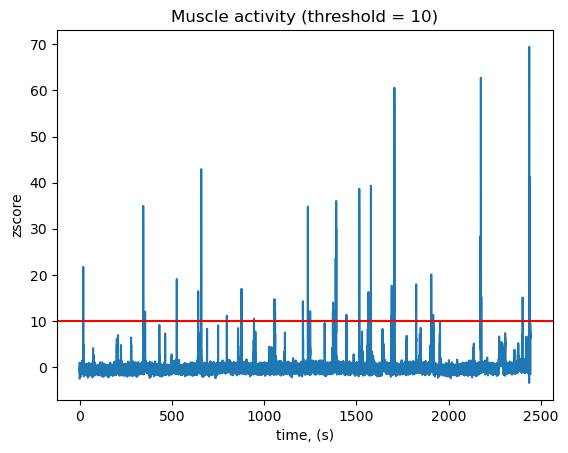

In [14]:
%matplotlib inline
fig1, ax = plt.subplots()
ax.plot(raw.times, scores_muscle);
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity (threshold = %s)' % threshold_muscle)

### Include annotations in dataset and inspect

Now mark all the annotations in the data set.

Calling set_annotations() replaces any annotations currently stored in the Raw object. To prevent that, we first extract their annotations and then combine them together with the blink and muscle annotations.

In [15]:
annotations_event = raw.annotations 
raw.set_annotations(annotations_event + annotations_blink + annotations_muscle)


<Raw | sub-01_ses-01_task-SpAtt_run-01_raw_hfc.fif, 71 x 2443460 (2443.5 s), ~1.29 GB, data loaded>

In [16]:
%matplotlib inline
raw.plot(start=50)

Using qt as 2D backend.


Channels marked as bad:
['R106_bz-s3', 's16_bz']


### Save the artefact annotations

Save the annotations in a file to be used in the subsequent sections:

In [17]:
raw.save(deriv_fname_fif_1, overwrite=True)
raw.annotations.save(deriv_fname_csv_1, overwrite=True)

Writing /home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif


/tmp/ipykernel_7233/3702277048.py:1: RuntimeWarning: This filename (/home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(deriv_fname_fif_1, overwrite=True)


Closing /home/rakshita/rds_folders/Sproject3/Emptyroom/Recordings/BIDSRec_main/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
[done]


### References

Muthukumaraswamy, S. (2013). High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616